# Лабораторная работа №4
Баранов Д.А. ИВТ 2.1

Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [25]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
# https://storage.yandexcloud.net/algorithmic-datasets/bus.zip
gdown.download('https://storage.yandexcloud.net/algorithmic-datasets/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/
!unzip -q "busl.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

[bus.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of bus.zip or
        bus.zip.zip, and cannot find bus.zip.ZIP, period.
replace /content/bus/Входящий/01009.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/bus/Входящий/03889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


['Выходящий', 'Входящий']

In [26]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [47]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [59]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}/{cls}'))

Входящий : ['04694.jpg', '00994.jpg', '00821.jpg', '04495.jpg', '05657.jpg', '02371.jpg', '02797.jpg', '05736.jpg', '02635.jpg', '04629.jpg', '01199.jpg', '04440.jpg', '02661.jpg', '03491.jpg', '03335.jpg', '06222.jpg', '04939.jpg', '05996.jpg', '00149.jpg', '04818.jpg', '05273.jpg', '06458.jpg', '02908.jpg', '03265.jpg', '02546.jpg', '01768.jpg', '03344.jpg', '02422.jpg', '01207.jpg', '01123.jpg', '03258.jpg', '01511.jpg', '00926.jpg', '00790.jpg', '04099.jpg', '03736.jpg', '00852.jpg', '01448.jpg', '04358.jpg', '03824.jpg', '00658.jpg', '01185.jpg', '03062.jpg', '00880.jpg', '04215.jpg', '01804.jpg', '01012.jpg', '05352.jpg', '06341.jpg', '00559.jpg', '00993.jpg', '06255.jpg', '03607.jpg', '04038.jpg', '00008.jpg', '01498.jpg', '01376.jpg', '05385.jpg', '01926.jpg', '06022.jpg', '00473.jpg', '00573.jpg', '04760.jpg', '03392.jpg', '04068.jpg', '01365.jpg', '04623.jpg', '00988.jpg', '04443.jpg', '02578.jpg', '06384.jpg', '05891.jpg', '01661.jpg', '04172.jpg', '01651.jpg', '04166.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

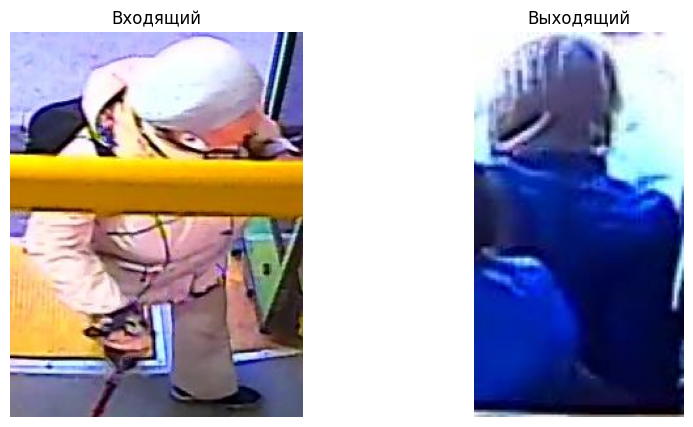

In [74]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    class_name = CLASS_LIST[i]
    if "Входящий" in class_name:
      class_name = class_name.replace("Входящий", "Входящий/")
    elif "Выходящий" in class_name:
      class_name = class_name.replace("Выходящий", "Выходящий/")

    car_path = f'{IMAGE_PATH}/{class_name}'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [77]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = os.path.join(IMAGE_PATH + class_name)  # Формирование полного пути к папке с изображениями класса
    if "Входящий" in class_name:
      class_name_modified = class_name.replace("Входящий", "Входящий/")
    elif "Выходящий" in class_name:
      class_name_modified = class_name.replace("Выходящий", "Выходящий/")
    else:
      class_name_modified = class_name

    class_path = os.path.join(IMAGE_PATH, class_name_modified)

    # Получаем список файлов в папке
    if os.path.isdir(class_path):
      class_files = os.listdir(class_path)
    else:
      class_path = os.path.dirname(class_path)
      class_files = [os.path.basename(class_name_modified)]

    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [os.path.join(class_path, file_name) for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


# 1. Загрузка и предобработка изображений

In [79]:
IMG_SIZE = 100 # PX
X = []
y = []

for img_path, label in zip(data_files, data_labels):
  try:
    img = image.load_img(img_path, target_size = (IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0 # Нормализация
    X.append(img_array)
    y.append(label)
  except Exception as e:
    print(f"Ошибка при обработке {img_path}: {e}")

X = np.array(X)
y = np.array(y)

print("Размер X:", X.shape)
print("Размер y:", y.shape)

Размер X: (9081, 100, 100, 3)
Размер y: (9081,)


# 2. Разделение на выборки

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
print("Обучающая выборка:", X_train.shape, y_train.shape)
print("Проверочная выборка:", X_val.shape, y_val.shape)

Обучающая выборка: (7264, 100, 100, 3) (7264,)
Проверочная выборка: (1817, 100, 100, 3) (1817,)


# 3. Построение модели CNN

In [83]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Обучение модели

In [84]:
start = time.time()

history = model.fit(
    X_train, y_train,
    epochs = 15,
    batch_size = 32,
    validation_data = (X_val, y_val)
)

end = time.time()
print(f"\n Время обучения: {round(end - start, 2)} сек.")

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7331 - loss: 0.5588 - val_accuracy: 0.7837 - val_loss: 0.4515
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7980 - loss: 0.4446 - val_accuracy: 0.8332 - val_loss: 0.3618
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8394 - loss: 0.3641 - val_accuracy: 0.8635 - val_loss: 0.3146
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8756 - loss: 0.3104 - val_accuracy: 0.8877 - val_loss: 0.2782
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8883 - loss: 0.2699 - val_accuracy: 0.9070 - val_loss: 0.2503
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8971 - loss: 0.2443 - val_accuracy: 0.9152 - val_loss: 0.2219
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9044 - loss: 0.2252 - val_accuracy: 0.9092 - val_loss: 0.2165
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9153 - loss: 0.2026 - val_acc

# 5. Визуализация и проверка точности

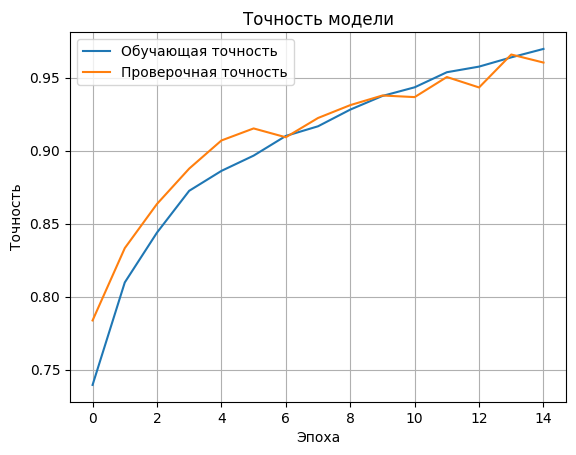


 Проверочная точность модели: 96.04%


In [85]:
plt.plot(history.history['accuracy'], label = 'Обучающая точность')
plt.plot(history.history['val_accuracy'], label = 'Проверочная точность')
plt.title('Точность модели')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.show()

# Проверка точности
loss, accuracy = model.evaluate(X_val, y_val, verbose = 0)
print(f'\n Проверочная точность модели: {accuracy * 100:.2f}%')